# Gibbs Sampling with PYMC

Sorry professor keene. I thought the Gibbs sampling paper would have been one of the 5 that you assigned during lecture but I didn't find any so i just implemented the causal inference one isntead because it mentioned gibbs sampling the most times LMAO   

In [1]:
import pytensor
pytensor.config.mode = "FAST_COMPILE"


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [n]


c:\Users\joshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.


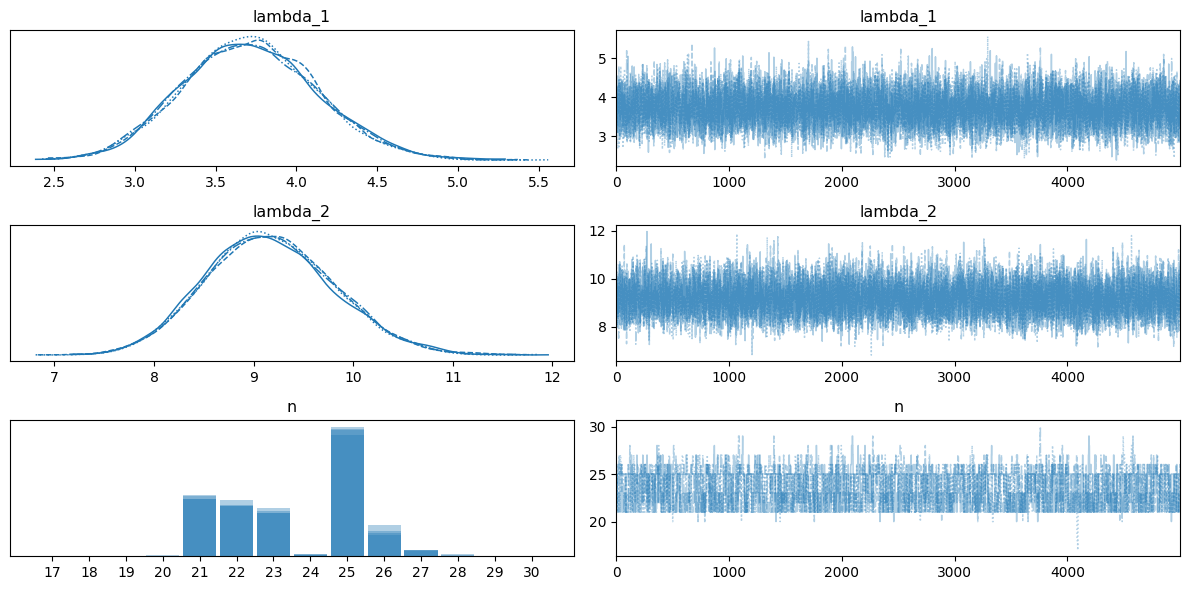

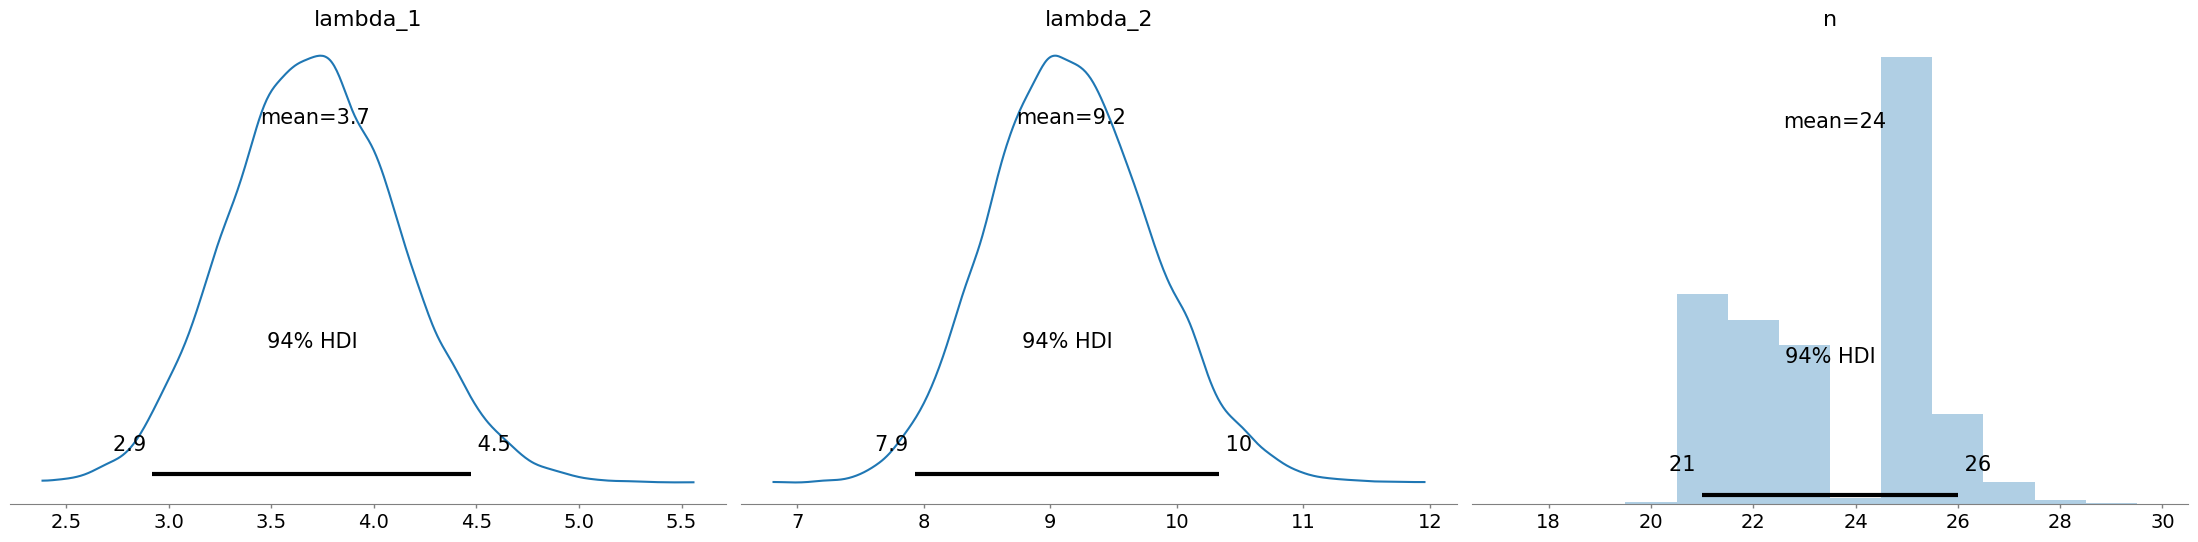

In [3]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Simulate synthetic change-point data
np.random.seed(0)
N = 50
true_n = 26
lambda_1_true = 4
lambda_2_true = 10

x = np.concatenate([
    np.random.poisson(lambda_1_true, true_n),
    np.random.poisson(lambda_2_true, N - true_n)
])

# Define the model
with pm.Model() as model:
    lambda_1 = pm.Gamma("lambda_1", alpha=2, beta=1)
    lambda_2 = pm.Gamma("lambda_2", alpha=2, beta=1)
    
    n = pm.DiscreteUniform("n", lower=0, upper=N-1)
    
    rate = pm.math.switch(np.arange(N) <= n, lambda_1, lambda_2)
    obs = pm.Poisson("obs", mu=rate, observed=x)

    # Use Metropolis for n (discrete) and NUTS for lambda_1 and lambda_2
    step = [
        pm.NUTS(vars=[lambda_1, lambda_2]),
        pm.Metropolis(vars=[n])
    ]

    trace = pm.sample(
        5000,
        tune=1000,
        step=step,
        return_inferencedata=True,
    )

# Plot trace and posterior
az.plot_trace(trace, var_names=["lambda_1", "lambda_2", "n"])
plt.tight_layout()
plt.show()

az.plot_posterior(trace, var_names=["lambda_1", "lambda_2", "n"])
plt.tight_layout()
plt.show()


# Stretch Goal: Manual Implementation of gibbs Sampling

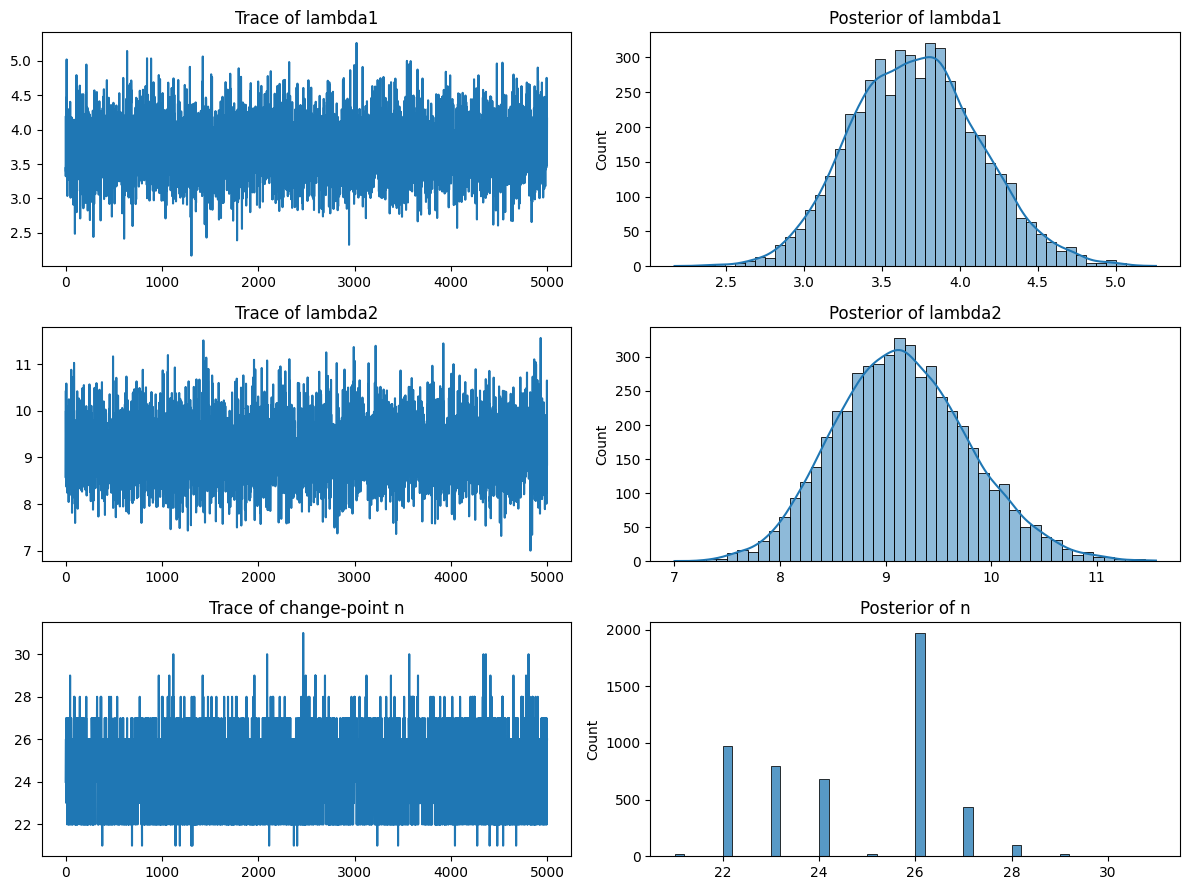

In [5]:
from scipy.special import gammaln
import seaborn as sns

# Hyperparameters
a = 2
b = 1
iterations = 5200
burn_in = 200

# Storage
samples_lambda1 = np.zeros(iterations)
samples_lambda2 = np.zeros(iterations)
samples_n = np.zeros(iterations, dtype=int)

# Initial values
lambda1 = np.random.gamma(a, 1/b)
lambda2 = np.random.gamma(a, 1/b)
n = np.random.randint(1, N)

for i in range(iterations):
    # Sample lambda1
    x1 = x[:n]
    shape1 = a + np.sum(x1)
    rate1 = b + len(x1)
    lambda1 = np.random.gamma(shape1, 1 / rate1)

    # Sample lambda2
    x2 = x[n:]
    shape2 = a + np.sum(x2)
    rate2 = b + len(x2)
    lambda2 = np.random.gamma(shape2, 1 / rate2)

    # Sample n
    log_probs = []
    for k in range(1, N):
        x1_k = x[:k]
        x2_k = x[k:]

        log_p1 = np.sum(x1_k * np.log(lambda1) - lambda1 - gammaln(x1_k + 1))
        log_p2 = np.sum(x2_k * np.log(lambda2) - lambda2 - gammaln(x2_k + 1))
        log_probs.append(log_p1 + log_p2)

    log_probs = np.array(log_probs)
    probs = np.exp(log_probs - np.max(log_probs))
    probs /= probs.sum()
    n = np.random.choice(np.arange(1, N), p=probs)

    samples_lambda1[i] = lambda1
    samples_lambda2[i] = lambda2
    samples_n[i] = n

# Discard burn-in
samples_lambda1 = samples_lambda1[burn_in:]
samples_lambda2 = samples_lambda2[burn_in:]
samples_n = samples_n[burn_in:]

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

axes[0, 0].plot(samples_lambda1)
axes[0, 0].set_title("Trace of lambda1")

axes[1, 0].plot(samples_lambda2)
axes[1, 0].set_title("Trace of lambda2")

axes[2, 0].plot(samples_n)
axes[2, 0].set_title("Trace of change-point n")

sns.histplot(samples_lambda1, ax=axes[0, 1], kde=True)
axes[0, 1].set_title("Posterior of lambda1")

sns.histplot(samples_lambda2, ax=axes[1, 1], kde=True)
axes[1, 1].set_title("Posterior of lambda2")

sns.histplot(samples_n, bins=N, ax=axes[2, 1], kde=False)
axes[2, 1].set_title("Posterior of n")

plt.tight_layout()
plt.show()
